<a href="https://colab.research.google.com/github/indra622/tutorials/blob/master/Multi_AI_Agent_Study/Part3_Ch1_02_Langraph_with_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q langgraph langchain python-dotenv langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00


In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [6]:
@tool
def get_weather(location: str):
  """ Call to get the weather"""
  if location in ["서울", "인천"]:
    return "It's 60 degress and foggy."
  else:
    return "It's 90 degress and sunny."

@tool
def get_coolest_cities():
  """Get a list of coolest cities"""
  return "서울, 고성"



In [7]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [10]:
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model = 'gpt-4o-mini', temperature = 0
).bind_tools(tools)

In [11]:
model_with_tools.invoke("서울의 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_BOKlshts00kBU8qko5q3KtUH',
  'type': 'tool_call'}]

In [12]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_UFnHFWQ3HkclKQk8jCju24GV',
  'type': 'tool_call'}]

In [13]:
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degress and foggy.", name='get_weather', tool_call_id='call_7rvZGXkOxbwO5Gl2JrTRxVjE')]}

In [17]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", END]:
  messages = state['messages']
  last_message = messages[-1]
  if last_message.tool_calls:
    return "tools"
  return END

def call_model(state: MessagesState):
  messages = state['messages']
  response = model_with_tools.invoke(messages)
  return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'agent')

workflow.add_conditional_edges(
    'agent',
    should_continue,
)

workflow.add_edge("tools", 'agent')

app=workflow.compile()

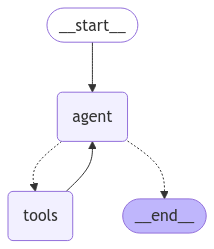

In [21]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [23]:
for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values",
):
  chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_WPuRTBVdtOHzKfrnK8qsMi4F)
 Call ID: call_WPuRTBVdtOHzKfrnK8qsMi4F
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_IsCE0DMBvPjeYdfFIAYcNZrk)
 Call ID: call_IsCE0DMBvPjeYdfFIAYcNZrk
  Args:
    location: 서울
  get_weather (call_FA82GeV78QuRrOJpjBdCjdU7)
 Call ID: call_FA82GeV78QuRrOJpjBdCjdU7
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degress and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도이며 안개가 낀 상태입니다. 반면, 고성의 날씨는 90도이며 맑은 날씨입니다.
